In [53]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [54]:
name = 'house'
name = 'library'
data_dir = 'data'

# images
I1 = plt.imread(data_dir + '/' + name + '/library1.jpg')
I2 = plt.imread(data_dir + '/' + name + '/library2.jpg')

# K matrices
qq = loadmat(data_dir + '/' + name + '/library1_K.mat')
K1 = qq['K']
print(K1.shape)
qq = loadmat(data_dir + '/' + name + '/library2_K.mat')
K2 = qq['K']

# corresponding points
matches = [x.split('  ')[1:] for x in open(data_dir + '/' + name + '/library_matches.txt').readlines()] 
matches = [[float(y) for y in x] for x in matches]
matches = np.array(matches)

# this is a N x 4 where:
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is the corresponding point in the second image

(3, 3)


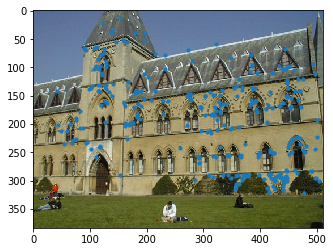

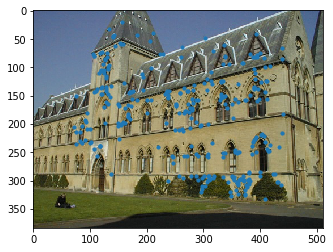

matches shape: (309, 4)


In [55]:

plt.imshow(I1)
plt.scatter(matches[:, 0], matches[:, 1], s = 10)
plt.show()
plt.imshow(I2)
plt.scatter(matches[:, 2], matches[:, 3], s = 10)
plt.show()
print("matches shape:", matches.shape)

In [72]:
'''The function that returns the fundamental matrix described in 1.4.1 (Eight Point Algorithm).
This function takes in atleast 8 corresponding points and returns the matrix F and the residual.
'''
def fundamental_matrix(matches):
    #TODO (do this with normalization)

    # normalize
    
    # write mean + std transformations as matrices
    set1 = matches[:, 0:2]
    set2 = matches[:, 2:4]
    
    """mean_fn1, std_fn1 = get_normalize_fns(set1)
    mean_fn2, std_fn2 = get_normalize_fns(set2)"""
    T_1 = get_normalize_mat(set1)
    T_2 = get_normalize_mat(set2)
    set1 = normalize(set1, T_1)
    set2 = normalize(set2, T_2)
    #print(set1)
    A = np.stack(
        [set1[:, 0] * set2[:, 0],
         set1[:, 1] * set2[:, 0],
         set2[:, 0],
         set1[:, 0] * set2[:, 1],
         set1[:, 1] * set2[:, 1],
         set2[:, 1],
         set1[:, 0],
         set1[:, 1],
         np.ones(set1[:, 0].shape)], axis=1)
    U, s, Vh = np.linalg.svd(A)
    F_star = Vh[-1].reshape(3, 3)
    U, s, Vh = np.linalg.svd(F_star)
    s[2] = 0
    return T_2.T @ U @ np.diag(s) @ Vh @ T_1

##Josh Added
'''
This function gets the normalization matrix that can be applied to a data point in HOMOGENOUS
coordinates
'''
def get_normalize_mat(s):
    mu = np.mean(s, axis=0)
    sigma = np.std(np.linalg.norm(s, axis=1))
    return 1/sigma * np.array([[1, 0 ,-mu[0]],
                               [0, 1, -mu[1]],
                               [0, 0,  sigma]])
####

# def normalize(s):
#     return (s - np.mean(s, axis=1).reshape(s.shape[0], 1)) / \
#             np.std(s, axis=1).reshape(s.shape[0], 1)
'''
This normalization method converts to homogenous coordinates to use the tranformation T.
I think this is the correct way
'''
def normalize(s, T):
    ones = np.ones(s.T[0].shape)
    s_prime = np.stack([s.T[0], s.T[1], ones], axis=0)
    return (T @ s_prime).T[:,:2]

def get_normalize_fns(s):
    mean = np.mean(s, axis=0)
    std = np.std(s, axis=0)
    s_homogenous = np.stack([s, np.ones(s.shape[0], 1)], axis=1).T
    
    mean_transformation = np.eye(3)
    mean_transformation[1]
    std_transformation = np.diag(1 / std)

'''Given E, calculates and returns both the rotation and translation between the two cameras.
Described in part 1.4.2. Returning the magnitude of t is impossible, so we return
an array of possible t's and an array of possible R's.
'''
def find_rotation_translation(E):
    U, Sigma, Vh = np.linalg.svd(E)
    S = U
    print(Sigma)
    #the two singular values should be the SAME
    R90_St_R = Vh
    R90t = np.array([[0, -1, 0],
                     [1, 0, 0],
                     [0, 0, 1]])
    R = S @ R90t.T @ R90_St_R
    
    t = S[:, 2]
    return [t, -t], [R, -R]

'''Triangulation function. This takes in the matches, P1, P2, and
finds the best 3D points that reproject to the images in the
two cameras.

This returns a Nx3 matrix of points in 3D space and the 
reconstruction scene. N depends on the number of points
that end up in front of the images planes.'''
def find_3d_points(matches, P1, P2):
    #TODO
    def get_X_and_err(x1, x2):
        A = np.array([[(P1[0,0] - x1[0]*P1[2,0]), (P1[0,1] - x1[0]*P1[2,1]), (P1[0,2] - x1[0]*P1[2,2])],
                      [(P1[1,0] - x1[1]*P1[2,0]), (P1[1,1] - x1[1]*P1[2,1]), (P1[1,2] - x1[1]*P1[2,2])],
                      [(P2[0,0] - x2[0]*P2[2,0]), (P2[0,1] - x2[0]*P2[2,1]), (P2[0,2] - x2[0]*P2[2,2])],
                      [(P2[1,0] - x2[1]*P2[2,0]), (P2[1,1] - x2[1]*P2[2,1]), (P2[1,2] - x2[1]*P2[2,2])]])
        b = np.array([[P1[0, 3] - x1[0]*P1[2, 3]],
                      [P1[1, 3] - x1[1]*P1[2, 3]],
                      [P2[0, 3] - x2[0]*P2[2, 3]],
                      [P2[1, 3] - x2[1]*P2[2, 3]]])
        X = np.linalg.lstsq(A, b)[0]
        X_hom = np.append(X, 1)
        x1_p = P1 @ X_hom
        x1_p = (x1_p/x1_p[2])[:2]
        x2_p = P2 @ X_hom
        x2_p = (x2_p/x2_p[2])[:2]

        err1 = np.linalg.norm(x1_p - x1)
        err2 = np.linalg.norm(x2_p - x2)
        print(x2, x2_p)
        
        if (X[2] < 0):
            return None
        #print(err1, err2)
        return X, (err1 + err2)/2
    
    Xs = []
    errs = []
    set1 = matches[:, 0:2]
    set2 = matches[:, 2:4]
    #set1, set2 = set2, set1
    for i in range(matches.shape[0]):
        x1, x2 = set1[i], set2[i]
        curr = get_X_and_err(x1, x2)
        if curr:
            Xs.append(curr[0].T.flatten())
            errs.append(curr[1])
#     print(np.array(Xs))
    return np.array(Xs), np.average(errs)

[3.23178368e+00 3.20446995e+00 2.43351846e-16]
[[ 4.49623741e+02  1.42355565e+01 -4.05147353e+02  5.61384012e+02]
 [-7.22750731e+01  5.12508191e+02 -1.92954929e+02  9.02755832e+00]
 [-2.88074276e-01 -1.19042156e-03 -9.57607330e-01  5.73622124e-02]]
[406.3635  82.941 ] [888.04461894  87.05738265]
[334.3105  93.6585] [773.01250427  96.98210931]
[115.988  109.5505] [432.65638423 111.6721279 ]
[123.7805 109.638 ] [440.79134982 111.81620533]
[313.5215 124.691 ] [759.50929298 126.51664113]
[402.4945 125.1375] [897.12030062 127.14283507]
[301.3955 127.592 ] [739.79290685 129.32252148]
[128.8755 135.331 ] [458.73068815 136.53666921]
[266.067  136.6225] [682.8563822  138.00069423]
[408.279  142.8805] [907.65426696 144.04981081]
[233.4485 144.9605] [632.60151788 145.79882484]
[397.4235 155.5095] [888.05577842 155.97372101]
[183.5325 157.9345] [552.6437544  158.09717553]
[337.553  164.9715] [796.15413245 165.13930998]
[171.071  191.5745] [531.54029189 190.26759124]
[287.1455 196.14  ] [718.629573

C:\Users\Sherman Luo\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[137.647 288.111] [501.12422002 283.01470951]
[309.323  299.6135] [777.37100074 292.28579694]
[387.212   82.3715] [853.45186718  86.95162924]
[389.0705 135.6235] [872.85912939 137.1649685 ]
[338.036 149.885] [796.2573587  150.40202539]
[357.696 316.694] [857.24412372 307.84014131]
[400.1835 285.6475] [910.00725221 278.27084973]
[168.338  145.6175] [512.9815365  146.48984865]
[319.214 291.726] [792.90073867 284.73788592]
[374.289 316.898] [883.26507102 307.82554485]
[391.4805 120.3655] [878.10461613 122.73623077]
[102.0885 232.682 ] [431.63374605 230.04094025]
[397.119  138.6725] [886.66769137 140.08963676]
[370.567  291.8205] [872.81270604 284.32222233]
[418.254 236.999] [939.13302993 232.50339232]
[389.3125 103.25  ] [875.90865236 106.62774733]
[351.3  164.15] [823.09144965 164.07254206]
[143.75  62.  ] [472.72486183  65.90436055]
[409.0555 100.361 ] [905.43614579 103.93136898]
[200.422  157.3595] [578.29575141 157.64082125]
[257.3125 210.8125] [684.72633567 208.51646282]
[ 75.472  23

C:\Users\Sherman Luo\Anaconda3\lib\site-packages\numpy\lib\function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Sherman Luo\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[133.398  95.574] [453.00356823  98.18492998]
[286.99 253.48] [734.88924253 248.93578734]
[316.5  295.25] [789.99527402 288.03795008]
[258.6875 145.896 ] [671.18025288 146.66999575]
[411.896 244.896] [930.83444631 239.87559289]
[122.3055  93.5555] [439.34846781  96.29467998]
[131.842  103.7765] [453.14809626 106.52018374]
[363.25   298.2965] [862.7609036  290.74403057]
[153.8055  59.0555] [487.38842028  63.11131188]
[360.5455 129.2955] [832.5433094  131.14727123]
[294.0775 204.3275] [735.60911186 202.40585658]
[158.8635  59.3865] [492.4945209   63.48735638]
[308.058 292.878] [776.71872222 286.07851516]
[371.675 301.675] [876.17650012 293.57734495]
[361.432  307.7725] [861.13898692 299.21670786]
[250.1215 210.3715] [666.97435096 208.25686624]
[408.3405 232.6165] [922.17076264 228.61413956]
[273.229 164.604] [696.43457287 164.57298049]
[358.5695 304.0415] [856.54836823 295.80657761]
[262.268 208.768] [688.96219083 206.63216436]
[439.146 216.646] [968.62507204 213.27048259]
[244.594  255.

[366.7465 297.732 ] [867.93538761 289.65394533]
[359.6535 302.0295] [857.84346396 293.83430312]
[342.908 302.247] [831.46036437 294.3861383 ]
[437.283  308.6795] [982.28724398 299.54534505]
[347.8805 319.626 ] [841.7209826  310.68493623]
[373.4115 325.4275] [884.45906522 315.75127216]
[409.3305 333.0935] [941.38657473 322.57958005]
[152.687  57.101] [485.94167543  61.29948171]
[107.215  80.123] [414.86997237  83.22519075]
[391.103   81.2505] [859.14164034  85.80220372]
[345.817  93.85 ] [789.92772959  97.73579205]
[390.981 136.257] [876.12371353 137.72581609]
[390.191  138.1175] [874.77421673 139.69132567]
[281.     140.7055] [707.8966597 141.7833206]
[236.7525 152.3485] [638.38612776 152.76873612]
[286.2055 158.42  ] [713.797563   158.67570434]
[265.0975 180.045 ] [688.33105625 179.26938458]
[167.262 186.816] [524.77287273 185.84141836]
[277.5525 189.4865] [701.49647544 188.09718293]
[154.5595 201.1245] [510.37490119 199.66937237]
[ 71.7965 206.013 ] [374.66205819 204.3291152 ]
[116.8

[316.1365 233.068 ] [777.34426968 229.30496473]
[ 74.514 214.764] [380.17787276 212.89881372]
[307.6015 299.7025] [774.96100365 292.3099531 ]
[264.0265 295.0425] [705.05600706 288.50230898]
[246.2355 268.544 ] [669.81783377 263.47831061]
[433.7615 241.6475] [964.14784434 236.7028665 ]
[270.683 141.948] [690.66679021 142.98344983]
[149.37  203.098] [501.63508948 201.60912607]
[ 81.8495 215.124 ] [389.6759603  213.18960277]
[376.2215 311.4525] [885.36254718 302.7316203 ]
[125.428   86.4975] [443.19903005  89.4028101 ]
[111.063 141.952] [429.00122981 142.79678976]
[359.593 251.465] [850.21422033 246.4878956 ]
[380.478  306.4065] [891.70812958 297.94301651]
[274.2625 178.578 ] [696.96439389 177.85136437]
[330.8505 150.199 ] [784.01846265 151.0075106 ]
[281.7995 162.6025] [707.83565697 162.68258485]
[166.9505 182.103 ] [523.00034891 181.2444986 ]
[149.129 164.95 ] [497.84470287 164.79448314]
[334.732  293.8855] [816.99131905 286.71998746]
[399.8055 291.5935] [919.93244522 283.80610847]
[131

[159.258  127.5645] [498.87933883 128.99571557]
[119.594 136.094] [441.97869789 137.22885031]
[121.338  135.6555] [446.24021319 136.73132056]
[268.   177.75] [691.94486158 177.02601956]
[334.7955 151.8635] [790.54062581 152.33859323]
[393.087  249.3585] [898.86623372 244.23416847]
[290.107  256.0475] [737.66539615 251.29563652]
[271.6 257.3] [707.8884513  252.61831474]
[378.847 298.347] [887.30314242 290.35534344]
[157.472  198.8335] [513.62711722 197.42755989]
[256.9425 180.904 ] [677.02099768 179.96312716]
[361.579  304.4585] [861.40100121 296.26053708]
[371.475 298.625] [875.65191829 290.76639112]
[247.0875 258.6625] [668.08650385 254.11089389]
[335.   124.75] [791.08115403 126.72711453]
[100.5785 209.365 ] [420.75605973 207.8223181 ]
[391.159  226.0455] [894.3549213 222.2937308]
[393.3125 222.729 ] [897.71464102 219.1203717 ]
[386.5555 239.1945] [889.79285095 234.6533877 ]
[306.0225 140.591 ] [747.29112417 141.76687251]
[388.325 231.625] [890.81034988 227.58891759]
[252.153  165.79

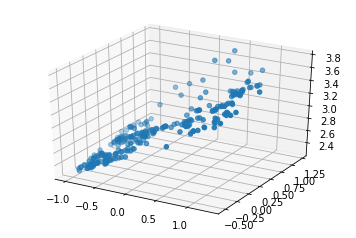

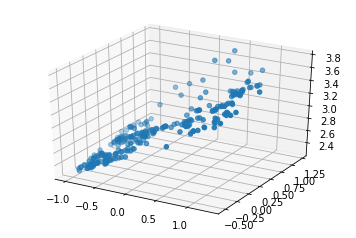

In [73]:
#TODO: visualize matches (maybe)

F = fundamental_matrix(matches)
#print('Residual in f = ', res_err)


#calculate the ESSENTIAL matrix from the FUNDAMENTAL matrix
E = K2.T @ F @ K1

# R : cell array with the possible rotation matrices of second camera
# t : cell array of the possible translation vectors of second camera
t, R = find_rotation_translation(E) 

#P1: P matrix for camera 1
#P2 is calculated on the fly since there are multiple possibilities
P1 = K1 @ np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0]])

# % the number of points in front of the image planes for all combinations
num_points = np.zeros((len(t), len(R)))
# % the reconstruction error for all combinations
errs = np.full((len(t), len(R)), np.inf)

for ti in range(len(t)):
    t2 = t[ti]
    for ri in range(len(R)):
        R2 = R[ri]
        P2 = K2 @ np.column_stack((R2, t2))
        print(P2)
        points_3d,  errs[ti, ri] = find_3d_points(matches, P1, P2) 
        if len(points_3d) == 0:
            continue
        #print("points_3d", points_3d.shape)
        #print(points_3d)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(points_3d[:, 0], points_3d[:, 1], zs=points_3d[:, 2])
        num_points[ti, ri] = points_3d.shape[0]
print(errs)